# CNN on MNIST

First I'll see how jax works, then I'll get serious and use Flax or Keras3 to train a CNN on MNIST.

I'll go for the smallest model I can with the best accuracy.

In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from jax import grad, jit, vmap
from jax import random

key = random.key(0)

In [ ]:
a = jnp.array([1,2,3], dtype=jnp.float32)
a

Array([1., 2., 3.], dtype=float32)

In [ ]:
b = a.clone()
b*=2
b

Array([2., 4., 6.], dtype=float32)

In [ ]:
def matmul(a,b):
	return a @ b
grad(matmul, (0,1))(a,b)

(Array([2., 4., 6.], dtype=float32), Array([1., 2., 3.], dtype=float32))

In [ ]:
t = random.normal(key, (32,32))
t

Array([[ 0.44198492,  1.4162407 ,  1.1836281 , ...,  0.76268387,
         1.6730201 , -0.7919397 ],
       [ 0.3699017 , -0.6458218 ,  0.34752584, ...,  0.37117738,
        -0.12576506,  0.15747534],
       [ 0.5894196 , -1.1405163 , -2.1414492 , ...,  0.32962143,
        -0.1306958 , -0.33589256],
       ...,
       [-0.34253454, -0.83690214,  0.2501121 , ..., -0.8274586 ,
        -0.37825716, -0.72685933],
       [-0.21192348,  1.0094156 , -1.3232409 , ...,  0.6742543 ,
         0.4670012 , -0.26775917],
       [ 2.217044  ,  0.9682738 ,  0.7508859 , ..., -0.51736134,
         0.43506762,  0.26947   ]], dtype=float32)

In [ ]:
jnp.linalg.inv(t)@t

Array([[ 1.0000000e+00, -4.3263549e-07,  3.2943905e-07, ...,
        -6.0542902e-07, -4.7928165e-07,  4.5479263e-07],
       [-5.6935903e-07,  1.0000002e+00, -1.5449623e-07, ...,
        -1.0179974e-06,  5.4067942e-07,  1.0584798e-06],
       [-4.1683845e-07,  3.9890290e-07,  1.0000001e+00, ...,
         2.8305678e-07,  6.5310269e-07,  1.7909557e-08],
       ...,
       [-3.0620704e-08, -1.6480183e-07,  1.0404414e-07, ...,
         9.9999994e-01,  4.8468581e-07,  5.3519943e-07],
       [ 1.4901161e-07, -7.4505806e-08,  9.6857548e-08, ...,
         1.7881393e-07,  9.9999988e-01, -1.2107193e-07],
       [-7.7113509e-07, -1.7881393e-07,  3.5762787e-07, ...,
        -1.4901161e-07,  2.6822090e-07,  1.0000006e+00]], dtype=float32)

Okay, seems simple enough, how do I load stuff into the GPU and JIT?

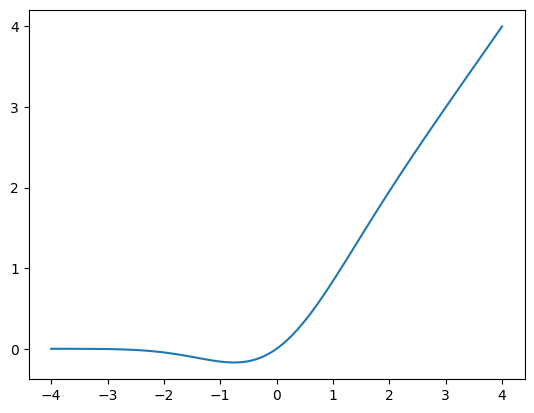

In [ ]:
def gelu(x):
	return 0.5*x*(1 + jnp.tanh(
		jnp.sqrt(2/jnp.pi)*(x + 0.044715*jnp.pow(x, 3))
	))

xs = jnp.linspace(-4,4, 100)
ys = gelu(xs)
plt.plot(xs, ys)

In [ ]:
%timeit gelu(xs).block_until_ready()

260 μs ± 49.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
gelu_jit = jit(gelu)

In [ ]:
%timeit gelu_jit(xs).block_until_ready()

9.12 μs ± 87.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


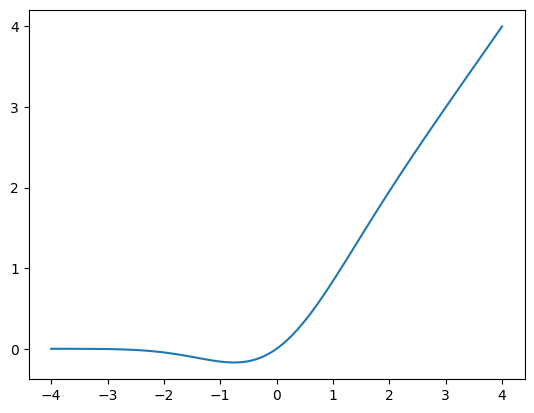

In [ ]:
plt.plot(xs, gelu_jit(xs))

JIT works real well! How about on GPU or other ways to parallelize?

In [ ]:
def mat_vec_mul(a,b):
	return a @ b

mat_vec_mul(jnp.array([[1,2], [3,4]]), jnp.array([[3], [4]]))

Array([[11],
       [25]], dtype=int32)

In [ ]:
def mat_mat_mul(a,b):
	return vmap(mat_vec_mul, (None, 1), 1)(a,b)


mat = jnp.array([[1,2], [3,4]])
print(mat@mat)
print(mat_mat_mul(mat, mat))

[[ 7 10]
 [15 22]]
[[ 7 10]
 [15 22]]


Okay I generally get the gist of it, let's see how to load objects into other devices.

In [ ]:
from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)

cpu
